# Routine to read in available sounding data and interpolate to regular height interval (single year)


https://weather.uwyo.edu/upperair/sounding.html

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 12})
import xarray as xr
import pandas as pd
from datetime import datetime
from datetime import timedelta

# meteorology - specific
from metpy.calc import relative_humidity_from_dewpoint
from metpy.units import units
from siphon.simplewebservice.wyoming import WyomingUpperAir

import sys
sys.path.append('./scripts/')

from LIB_dates import generate_date_list
from LIB_request_WUA_sounding import check_for_WUA_soundings
from LIB_sounding_analysis import (interpolate_soundings, 
                                   saturation_vaporpressures_from_temperature,
                                   relative_humidity_from_temperature_pressure)
from LIB_sounding_date_checks import grab_sounding_dates

### Specify parameters to retreive sounding data

season should be either 'winter', 'spring', 'summer', 'autumn', or 'all' for all year

In [13]:
# specify year, season, sounding hours
# specify site and height range
#===============================
year = 1998
season = 'summer'
hours = [12]

station = 'PABR'

max_height = 6*units.kilometer
min_height =  0*units.kilometer
bin_width = 0.1*units.kilometer
#===============================

# julian day ranges for each season
season_bounds = {}
season_bounds['winter'] = {'start': 0,   'end': 91}
season_bounds['spring'] = {'start': 91,  'end': 182}
season_bounds['summer'] = {'start': 182, 'end': 274}
season_bounds['autumn'] = {'start': 274, 'end': 366}

# find all julian days (/hours) with soundings for given year
doy, sou, year = grab_sounding_dates(csv=f'./sounding_checks/checked_{year}0101Z00_{year}1231Z23_hourly6.csv', hours=hours)
days_with_soundings = doy[sou==1]

# crop days to specified season
if str(season) == 'all':
    doy_soundings = days_with_soundings
else:
    doy_soundings = days_with_soundings[(days_with_soundings>(season_bounds[season]['start']))&
                                          (days_with_soundings<=(season_bounds[season]['end']))]


### Retrieve and interpolate data

In [14]:
all_RH = np.array([])
all_RH_liq = np.array([])
all_RH_ice = np.array([])
all_T = np.array([])
all_dates = np.array([])
all_doy = np.array([])

for ii in range(len(doy_soundings)):
    
    # create date
    doy = int(doy_soundings[ii]) # round down to julian day
    hour = int(24*(doy_soundings[ii]%1)) # grab hours
    date = datetime.strptime(f'{year}-{doy}-{hour}', '%Y-%j-%H')
    
    print(date)
    
    # request data using siphon
    # try request multiple times in case there is error with first
    num_tries = 5
    for attempt in range(num_tries):
        try:
            df = WyomingUpperAir.request_data(date, station)
            worked = True
        except:
            worked = False
        if worked == True:
            break
    if worked == False:
        df = []
        print(f"No data available for {date}")
            
    # if data request was succesful:
    # pull out T, Td, H and calculate RH
    #-----------------------------------
    if len(df) > 0:

        # assign units to all data
        height = df['height'].values * units(df.units['height']).to(units.kilometer)
        temperature = df['temperature'].values * units(df.units['temperature'])
        dewpoint = df['dewpoint'].values * units(df.units['dewpoint'])
        pressure = df['pressure'].values * units(df.units['pressure'])

        # crop all to below 10 km
        H = height[height < 10*units.kilometer]
        T = temperature[height < 10*units.kilometer]
        Td = dewpoint[height < 10*units.kilometer]
        P = pressure[height < 10*units.kilometer]

        # calculate relative humidity
        #----------------------------

        # using metpy:
        RH = relative_humidity_from_dewpoint(T, Td).to('percent')

        # using own fuctions from formulas found in literature (and some metpy)
        RH_liq, RH_ice = relative_humidity_from_temperature_pressure(P, Td, T, method = 'improved_magnus_1996')

    # interpolate 
    #-----------------------------------  

    try:
        [new_RH_liq, new_RH_ice, new_RH, new_T], new_H, edges = interpolate_soundings(variable = [RH_liq, RH_ice, RH, T], heights = H, 
                                                              bin_width = bin_width, min_height = min_height, 
                                                              max_height = max_height, method = 'mean', 
                                                              suppress_plots = True, suppress_prints = True)
        all_RH_liq = np.append(all_RH_liq, new_RH_liq)
        all_RH_ice = np.append(all_RH_ice, new_RH_ice)
        all_RH = np.append(all_RH, new_RH)
        all_T = np.append(all_T, new_T)
        all_dates = np.append(all_dates, date)
        all_doy = np.append(all_doy, doy_soundings[ii])
    
    except:
        print(f'  - issue with retrieval on {date}')
        
# reshape to dimensions: date, height
RH_liq = np.reshape(all_RH_liq, (int(len(all_RH_liq)/len(new_H)), len(new_H)))
RH_ice = np.reshape(all_RH_ice, (int(len(all_RH_ice)/len(new_H)), len(new_H)))
RH = np.reshape(all_RH, (int(len(all_RH)/len(new_H)), len(new_H)))
T = np.reshape(all_T, (int(len(all_T)/len(new_H)), len(new_H)))

# create grids to plot with pcolormesh
H, dates = np.meshgrid(new_H.magnitude, all_dates)
H, DOY = np.meshgrid(new_H.magnitude, all_doy)


# assign RH ice values to nan if T > 0 C
for ii in range(np.shape(RH_ice)[0]):
    for jj in range(np.shape(RH_ice)[1]):
        if T[ii][jj]>0*units('degC'):
            RH_ice[ii][jj] = np.nan
            

1998-07-01 12:00:00
1998-07-02 12:00:00
1998-07-03 12:00:00
1998-07-04 12:00:00
1998-07-05 12:00:00
1998-07-06 12:00:00
1998-07-07 12:00:00
1998-07-08 12:00:00
1998-07-09 12:00:00
1998-07-10 12:00:00
1998-07-11 12:00:00
1998-07-12 12:00:00
1998-07-13 12:00:00
1998-07-14 12:00:00
1998-07-15 12:00:00
1998-07-16 12:00:00
1998-07-17 12:00:00
1998-07-18 12:00:00
1998-07-19 12:00:00
1998-07-20 12:00:00
1998-07-21 12:00:00
1998-07-22 12:00:00
1998-07-23 12:00:00
1998-07-24 12:00:00
1998-07-25 12:00:00
1998-07-26 12:00:00
1998-07-27 12:00:00
1998-07-28 12:00:00
1998-07-29 12:00:00
1998-07-30 12:00:00
1998-07-31 12:00:00
1998-08-01 12:00:00
1998-08-03 12:00:00
1998-08-04 12:00:00
1998-08-05 12:00:00
1998-08-06 12:00:00
1998-08-07 12:00:00
1998-08-08 12:00:00
1998-08-09 12:00:00
1998-08-10 12:00:00
1998-08-11 12:00:00
1998-08-12 12:00:00
1998-08-13 12:00:00
1998-08-14 12:00:00
1998-08-15 12:00:00
1998-08-16 12:00:00
1998-08-17 12:00:00
1998-08-18 12:00:00
1998-08-19 12:00:00
1998-08-20 12:00:00


### plot seasonal relative humidity and temperatures

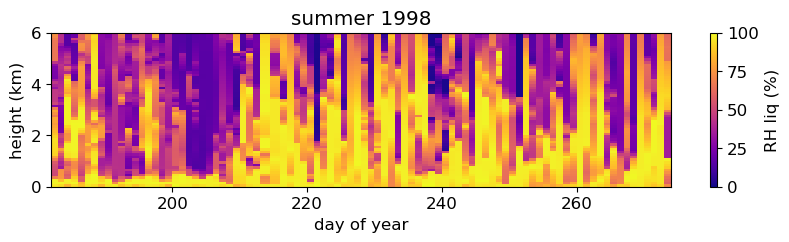

RH ice assigned to nan when T > 0 degC


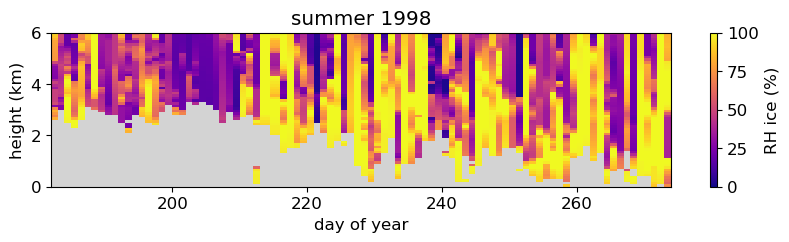

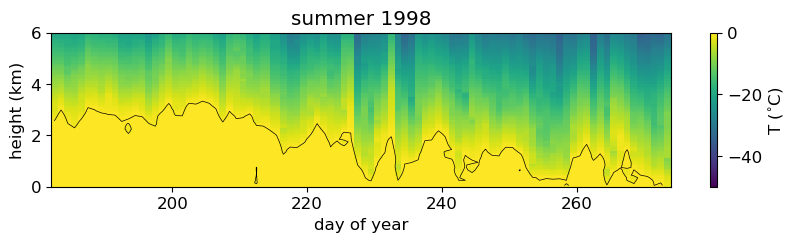

In [15]:
# relative humidity w.r.t. liquid
#--------------------------------
fig, ax = plt.subplots(figsize=(10,2))
rh = ax.pcolormesh(DOY, H, RH_liq, vmin=0, vmax=100, cmap='plasma')
plt.colorbar(rh, label='RH liq (%)')
ax.set_title(f'{season} {year}')
ax.set_ylabel('height (km)')
ax.set_xlabel('day of year')
plt.show()

# relative humidity w.r.t. ice
#-----------------------------
fig, ax = plt.subplots(figsize=(10,2))
ax.set_facecolor('lightgray')
rh = ax.pcolormesh(DOY, H, RH_ice, vmin=0, vmax=100, cmap='plasma')
plt.colorbar(rh, label='RH ice (%)')
ax.set_title(f'{season} {year}')
ax.set_ylabel('height (km)')
ax.set_xlabel('day of year')
print('RH ice assigned to nan when T > 0 degC')
plt.show()

# temperature
#------------
fig, ax = plt.subplots(figsize=(10,2))
t = ax.pcolormesh(DOY, H, T, vmin=-50, vmax=0)
ax.contour(DOY, H, T, colors='k', linewidths=0.5, levels=[0], vmin=-50, vmax=0)
plt.colorbar(t, label='T ($^{\circ}$C)')
ax.set_title(f'{season} {year}')
ax.set_ylabel('height (km)')
ax.set_xlabel('day of year')
plt.show()

### Plot frequency of RH threshold passed seasonall as a function of height

Text(0.5, 0, 'frequency (%)')

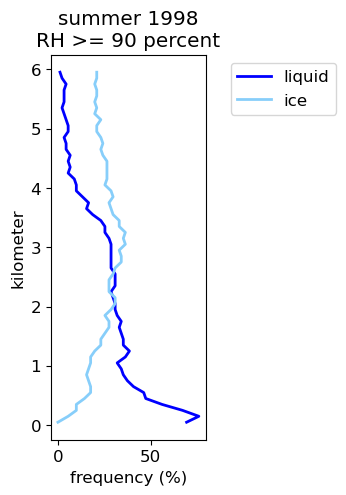

In [18]:
#===========================
rh_thresh = 90*units.percent
#===========================


fig, ax = plt.subplots(figsize=(2,5))

# liquid RH
ax.plot(100*np.sum(RH_liq>=rh_thresh, axis=0)/RH.shape[0], 
        new_H, color='blue', lw = 2, label='liquid')

# ice RH
# nans (T > 0 C) will present as not exceeding threshold
ax.plot(100*np.sum(RH_ice>=rh_thresh, axis=0)/RH.shape[0], 
        new_H, color='lightskyblue', lw = 2, label='ice')

plt.legend(loc=9,bbox_to_anchor=(1.5,1))
ax.set_title(f'{season} {year}\nRH >= {rh_thresh}')
ax.set_xlabel('frequency (%)')

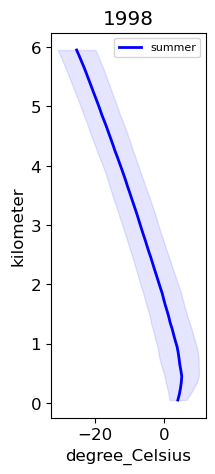

In [19]:

def plot_var_spread(ax, var, color='red', label = 'winter'):
    ax.plot(np.nanmean(var, axis=0), new_H, color=COLOR, lw = 2, label=label)
    ax.fill_betweenx(new_H,
                     np.nanmean(var.magnitude, axis=0)-np.nanstd(var.magnitude, axis=0), 
                     np.nanmean(var.magnitude, axis=0)+np.nanstd(var.magnitude, axis=0),
                     alpha=0.1, zorder=-1, color=COLOR)
    
    
fig, ax = plt.subplots(figsize=(2,5))

#==========
VAR = T
#==========

COLOR = 'blue'
plot_var_spread(ax, VAR, color=COLOR, label = season)

ax.set_title(f'{year}')
plt.legend(fontsize=8)
